## Setup

In [1]:
%run code.py
%matplotlib inline
time_all_start = datetime.now()

In [2]:
# file and tree names

# MC
sig_file_name = 'data/all_el.root'
bkg_file_name = 'data/all_mu.root'
sig_tree  = 'electron_mc'
bkg_tree  = 'muon_mc'

# data
# sig_tree  = 'electron_tags'
# bkg_tree  = 'muons'

In [3]:
# other settings

fit_verbose = 1

# max_epochs = 100
max_epochs = 20
max_epochs_model_default = 100


default_to_load = True

rnd_seed = 7

plot_mi = True

## Setup variables to train on

In [4]:
input_variables = OrderedDict([
    ('p',['$p$','default']),
    ('pT',['$p_{\mathrm{T}}$','default']),
    ('eta',['$\eta$','symmetric']),
    ('nTRThitsMan',['nTRT','default']),
    ('nTRTouts',['nTRT outs','default']),
    ('fHTMB',['Fraction HTMB','default']),
    ('fAr',['Fraction Ar','default']),
    ('trkOcc',['Track Occ.','default']),
    ('sumToTsumL',['$\sum\mathrm{ToT} / \sum L$','default']),
    ('eProbHT',['eProbHT','default']),
#    ('lep_pT',['$p_{\mathrm{T}}^{\mathrm{lep}}$','default']),
#    ('phi',['$\phi$','default']),
])

## vars to test
# PHF
# NhitsdEdx

# sumToT, sumL

# try adding eProbHT to see what else the network has learned

# all the hit vars, arrays of length 40 for use in RNN LSTM

# uninteresting vars - info is already included elsewhere
# nTRThits, nArhits, nXehits, nHThitsMan, nPrechitsMan

In [5]:
var_names_dict = {k:v[0] for (k,v) in input_variables.items()}

In [6]:
var_comb_dir = ''
for i,v in enumerate(input_variables.keys()):
    if i != 0: var_comb_dir += '_'
    var_comb_dir += v
plots_path = 'plots/'+var_comb_dir
models_path = 'models/'+var_comb_dir
make_path(plots_path)
make_path(models_path)

In [7]:
# df_sig, df_bkg, X_train, X_test, y_train, y_test = create_df_tts_scale(
#    sig_file_name, sig_tree, bkg_file_name, bkg_tree,
#    list(input_variables),
#    test_size=0.2,
#    # test_size=0.333333,
#    # sig_n=50000,
#    # bkg_n=50000,
#    shuffle=True,
#    scale_style={i:v[1] for i,(_,v) in enumerate(input_variables.items())}
# )

# TODO WARNING df_'s are not weighted!

df_sig, df_bkg, X_train, X_test, y_train, y_test = create_fixed_test_shuffled_train_and_scale(
    sig_file_name, sig_tree, bkg_file_name, bkg_tree,
    list(input_variables),
    test_size=0.2,
    # test_size=0.333333,
    # sig_n=50000,
    # bkg_n=50000,
    scale_style={i:v[1] for i,(_,v) in enumerate(input_variables.items())},
    rnd_seed = rnd_seed
)

val_data=(X_test, y_test) # Always use the same test data for non-kfold runs

In [8]:
input_ndimensions = X_train.shape[1]
leptons_m = y_train.shape[0]

print("Training on m = %.2g leptons\nTesting on %.2g leptons (50/50 e/mu)\nNumber of input variables n = %d" % (leptons_m, y_test.shape[0], input_ndimensions))

Training on m = 1.4e+06 leptons
Testing on 2.9e+05 leptons (50/50 e/mu)
Number of input variables n = 10


In [9]:
if False:
    print(df_sig.head(3))
    print(X_train.shape)
    print(X_train[:2])

## Create eProbabilityHT curves

In [10]:
# TODO this technically has the issue with the high pT events, but shouldn't actually be visible on plots
el_eprob = uproot.open(sig_file_name)[sig_tree].array('eProbHT')
mu_eprob = uproot.open(bkg_file_name)[bkg_tree].array('eProbHT')

m_eprob = min(el_eprob.shape[0], mu_eprob.shape[0])
el_eprob = el_eprob[:m_eprob]
mu_eprob = mu_eprob[:m_eprob]
print('Using %.2g el, %.2g mu for eProbHT' % (el_eprob.shape[0], mu_eprob.shape[0]))

roc_eprob_obj = eprob_roc_generateor(el_eprob, mu_eprob)

roc_eprob = [roc_eprob_obj.tpr(), roc_eprob_obj.fpr(), 'eProbHT', 'eprob', 'black', '-']

Using 7.2e+05 el, 7.2e+05 mu for eProbHT


## Plot input variables

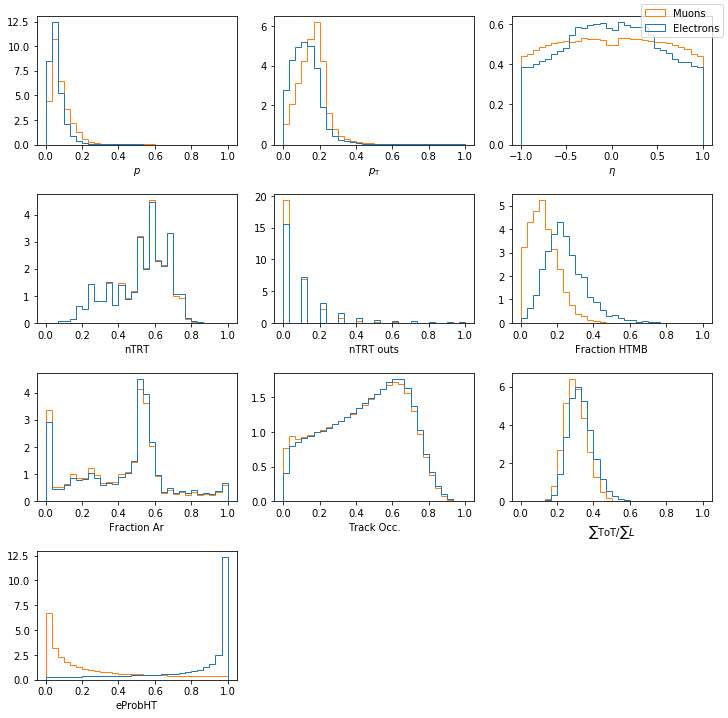

In [11]:
plot_all_input_vars(input_variables, X_train, y_train, plots_path)

In [12]:
if 'lep_pT' in list(input_variables):
    lep_pT_bins = [0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.4, 1.0]
    slice_and_plot_all_input_vars('lep_pT', '$p_{\mathrm{T}}^{\mathrm{lep}}$', lep_pT_bins, 
                                  input_variables, X_train, y_train, plots_path)

In [13]:
# plot_scale_example(sig_file_name,sig_tree,plots_path,'p','$p$ [GeV]'
# plot_scale_example(sig_file_name,sig_tree,plots_path,'pT','$p_{\mathrm{T}}$ [GeV]')

# SVM (sklearn)

In [14]:
svm_m = min(50000, y_train.shape[0])

In [15]:
fname_svm1 = 'svm1'
train_load_svm1 = train_or_load(models_path+'/'+fname_svm1+'.pkl', default_to_load)

Model NOT found on disk, training


In [16]:
if train_load_svm1 == 'n':
    
    # create
    svm1 = svm.SVC(#C=1.0, #kernel='rbf', #tol=0.001, #gamma='auto',
    probability=True,
    verbose=False);

    # train
    train_start = datetime.now()

    svm1.fit(X_train[:svm_m],y_train[:svm_m]);

    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to pickle
    joblib.dump(svm1, models_path+'/'+fname_svm1+'.pkl');
    
else:
    # load model from pickle
    svm1 = joblib.load(models_path+'/'+fname_svm1+'.pkl');

Training time: 0 hours, 3 minutes, 54 seconds


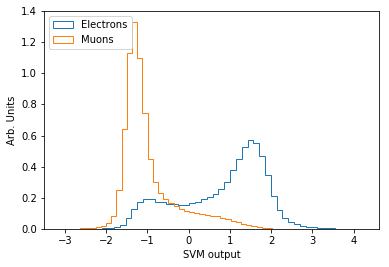

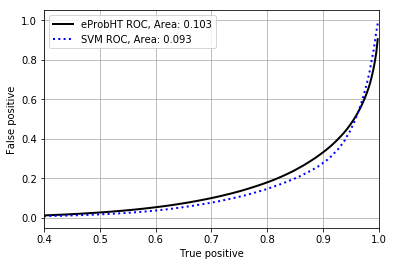

In [17]:
plot_classifier_1D_output(svm1.decision_function(X_test[y_test>0.5]), # el
                          svm1.decision_function(X_test[y_test<0.5]), # mu
                          'SVM', 'svm', plots_path
                          #, 'Default sklearn.svm.SVC settings'
                         )

fpr_svm1, tpr_svm1, thresholds_svm1 = roc_curve(y_test, svm1.decision_function(X_test))
roc_svm1 = [tpr_svm1, fpr_svm1, 'SVM', 'svm', 'blue', ':']

plot_roc([roc_eprob, roc_svm1], plots_path)

# Keras / Tensorflow work

In [18]:
# fix random seed for reproducibility
np.random.seed(rnd_seed)

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.models import load_model

Using TensorFlow backend.


## Default

In [19]:
fname_model_default = 'model_default'
train_load_model_default = train_or_load(models_path+'/'+fname_model_default+'.h5', default_to_load)

Model NOT found on disk, training


In [20]:
if train_load_model_default == 'n':
    
    # create
    model_default = Sequential()
    model_default.add(Dense(12, input_dim=input_ndimensions, activation='relu'))
    model_default.add(Dense(8, activation='relu'))
    model_default.add(Dense(1, activation='sigmoid'))

    model_default.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_default = model_default.fit(X_train, y_train,
                                           epochs=max_epochs_model_default, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_default = hist_model_default.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_default.save(models_path+'/'+fname_model_default+'.h5')
   
    with open(models_path+'/'+fname_model_default+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_default, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_default = load_model(models_path+'/'+fname_model_default+'.h5')
    
    with open(models_path+'/'+fname_model_default+'_hist.pickle', 'rb') as handle:
        hist_dict_model_default = pickle.load(handle)

Train on 1387623 samples, validate on 286530 samples
Epoch 1/100
1387623/1387623 [==============================] - 30s 21us/step - loss: 0.3728 - acc: 0.8348 - val_loss: 0.3913 - val_acc: 0.8245
Epoch 2/100
1387623/1387623 [==============================] - 30s 21us/step - loss: 0.3641 - acc: 0.8392 - val_loss: 0.3750 - val_acc: 0.8316
Epoch 3/100
1387623/1387623 [==============================] - 30s 22us/step - loss: 0.3615 - acc: 0.8399 - val_loss: 0.3773 - val_acc: 0.8293
Epoch 4/100
1387623/1387623 [==============================] - 30s 22us/step - loss: 0.3603 - acc: 0.8399 - val_loss: 0.3722 - val_acc: 0.8315
Epoch 5/100
1387623/1387623 [==============================] - 30s 22us/step - loss: 0.3596 - acc: 0.8400 - val_loss: 0.3771 - val_acc: 0.8298
Epoch 6/100
1387623/1387623 [==============================] - 30s 22us/step - loss: 0.3594 - acc: 0.8403 - val_loss: 0.3771 - val_acc: 0.8282
Epoch 7/100
1387623/1387623 [==============================] - 28s 20us/step - loss: 0.35

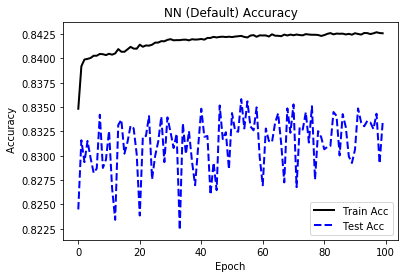

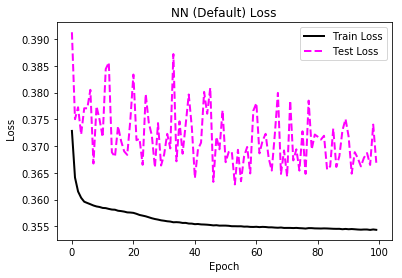

In [21]:
plot_acc_loss_vs_epoch(hist_dict_model_default, 'NN (Default)', 'nn_default', plots_path, 'Test', True, False)
plot_acc_loss_vs_epoch(hist_dict_model_default, 'NN (Default)', 'nn_default', plots_path, 'Test', False, True)

model_default acc: 83.34%


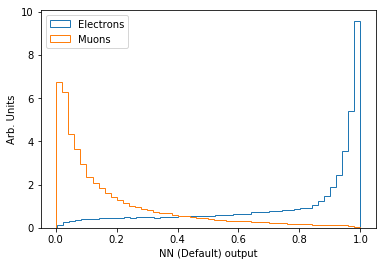

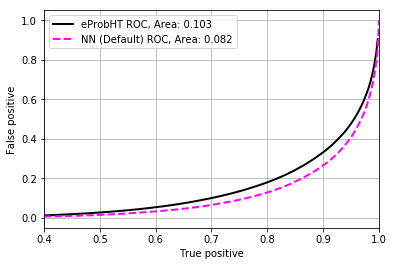

In [22]:
print("model_default %s: %.2f%%" % (model_default.metrics_names[1], model_default.evaluate(X_test,y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_default.predict(X_test[y_test>0.5], verbose=0), # el
                          model_default.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (Default)', 'nn_default', plots_path
                         )

fpr_model_default, tpr_model_default, thresholds_model_default = roc_curve(y_test, model_default.predict(X_test, verbose=0))
roc_model_default = [tpr_model_default, fpr_model_default, 'NN (Default)', 'nn_default', 'magenta', '--']

plot_roc([roc_eprob, roc_model_default], plots_path)

### Print and plot model_default structure

In [23]:
model_default.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                132       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [24]:
from keras.utils.vis_utils import plot_model
# pip install pydot

plot_model(model_default, to_file='plots/model_default.pdf', show_shapes=True, show_layer_names=True)

## Print input variable plots vs default NN ouptut

In [25]:
input_variables_with_model_default_output = input_variables.copy() 
input_variables_with_model_default_output['model_default_nn_output'] = ['NN (Default) Output', 'leave']
model_default_output_bins = [0.0, 0.05, 0.1, 0.15, 0.2,
                             0.4, 0.6,
                             0.8, 0.85, 0.9, 0.95, 1.0]

X_train_with_model_default_output = np.append(X_train, model_default.predict(X_train, verbose=0), axis=1)

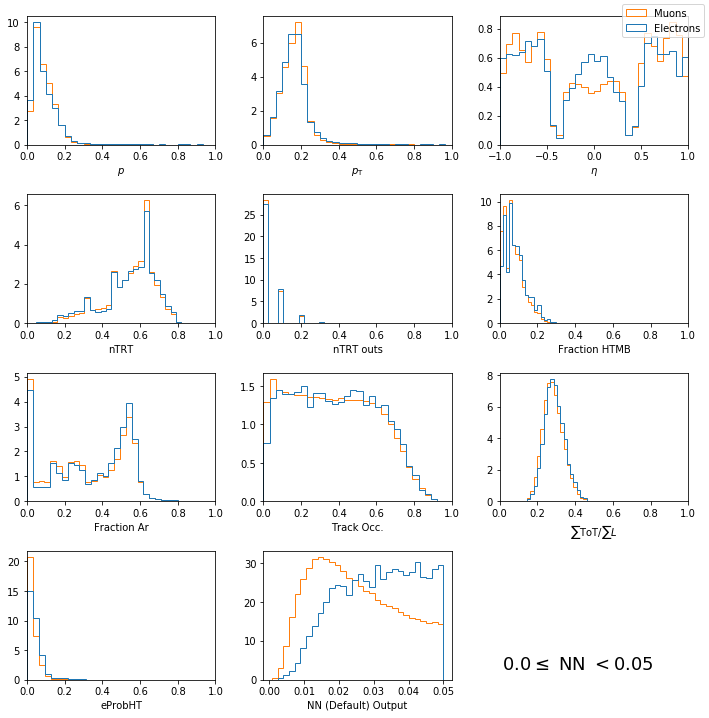

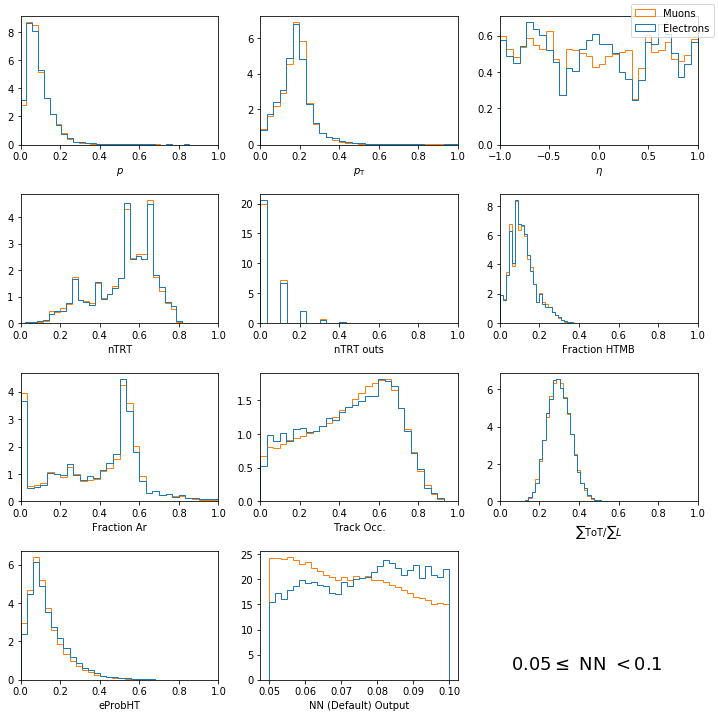

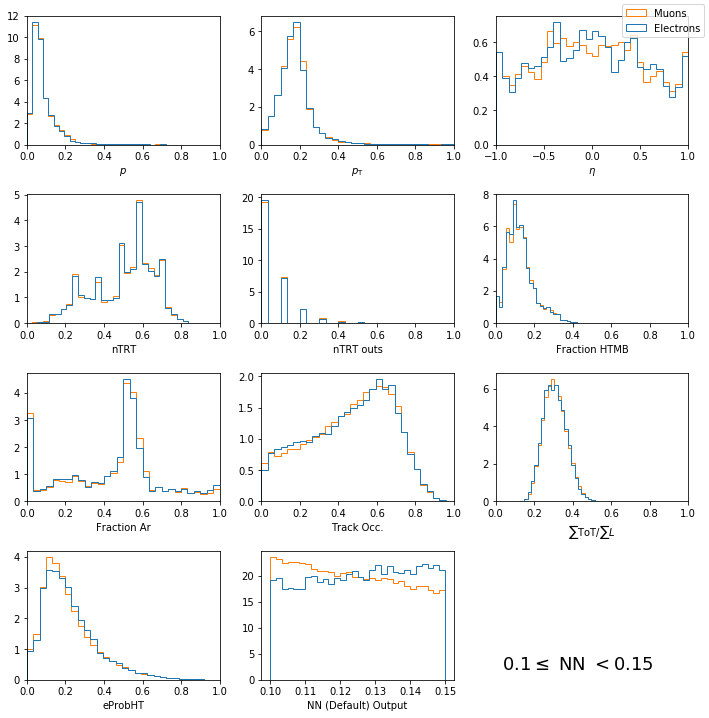

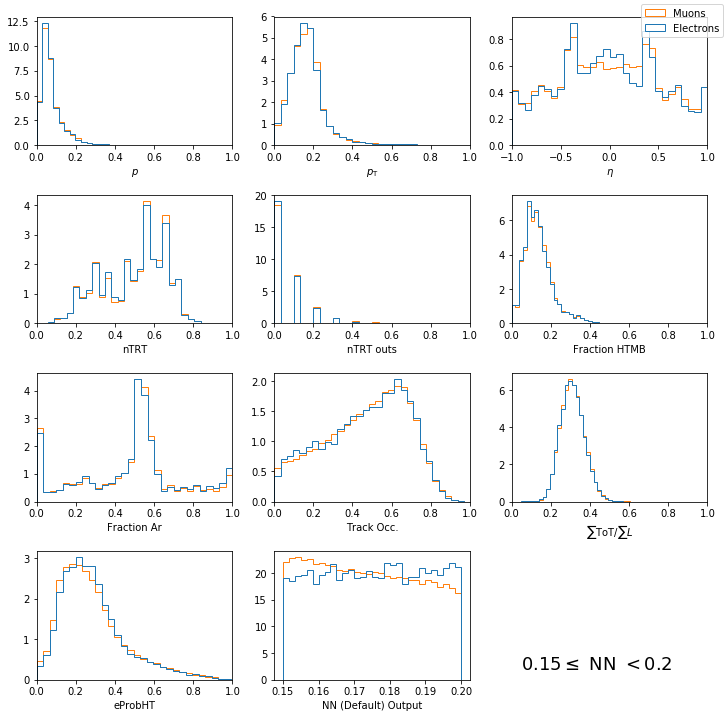

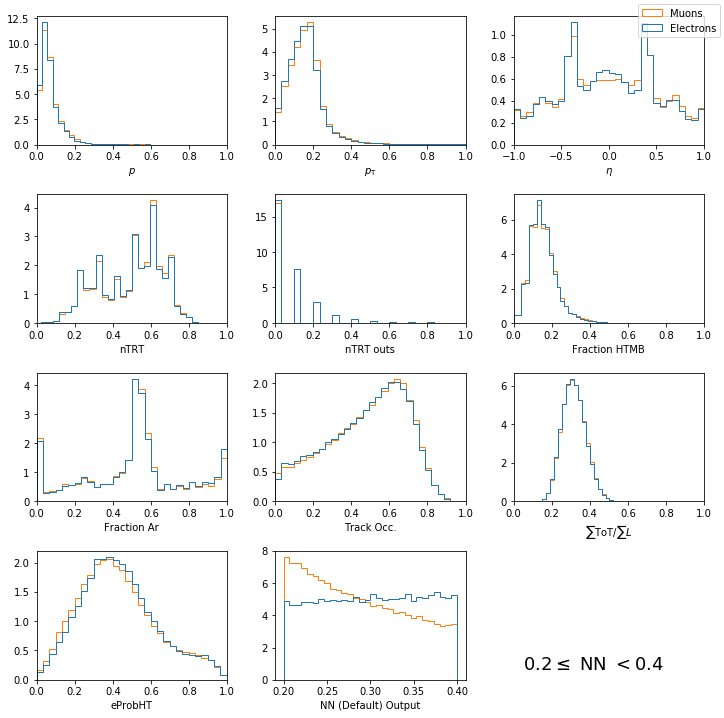

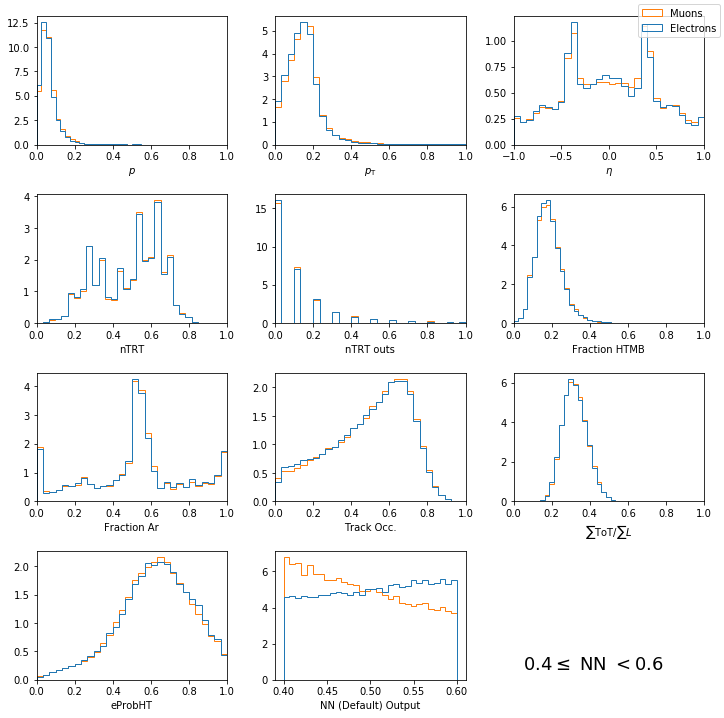

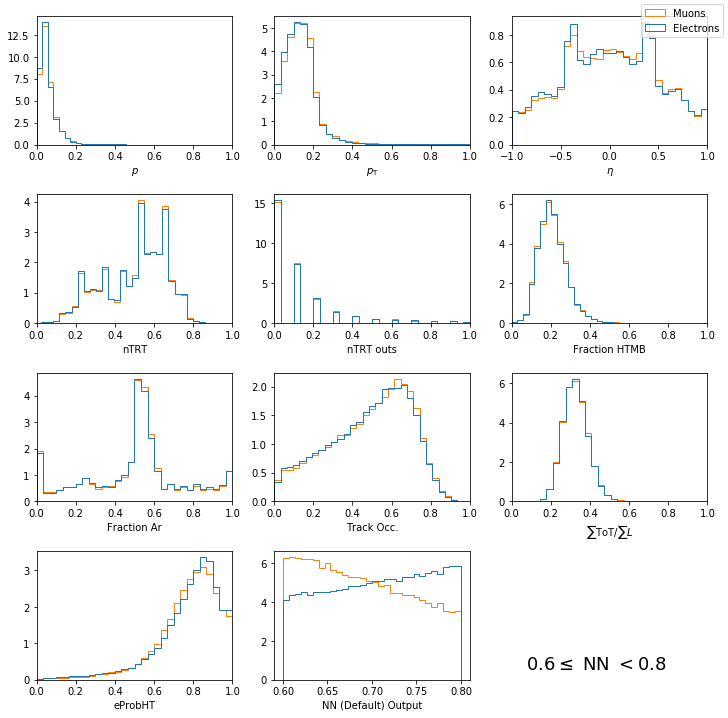

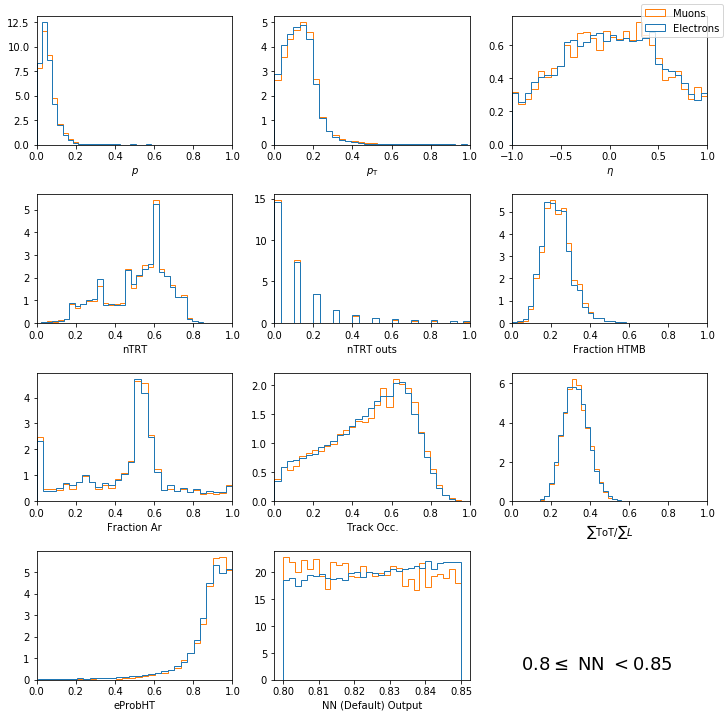

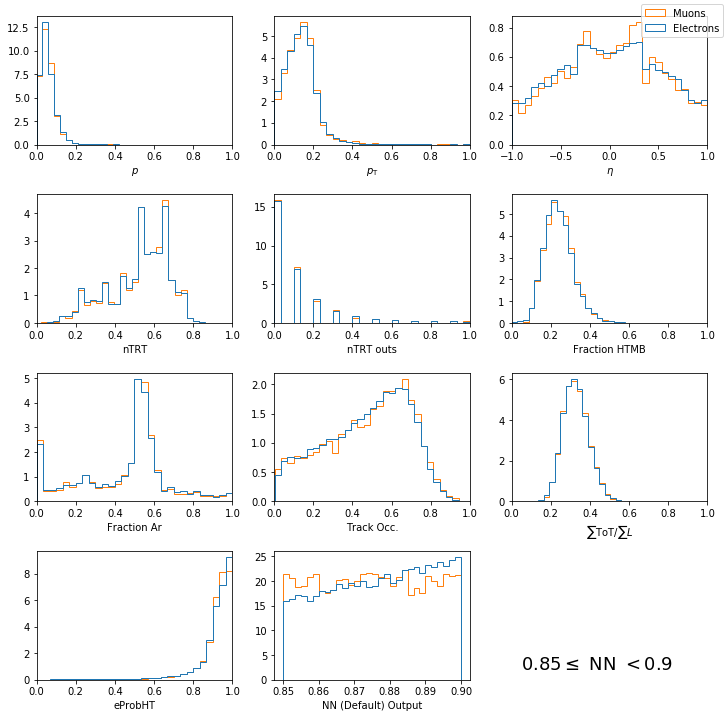

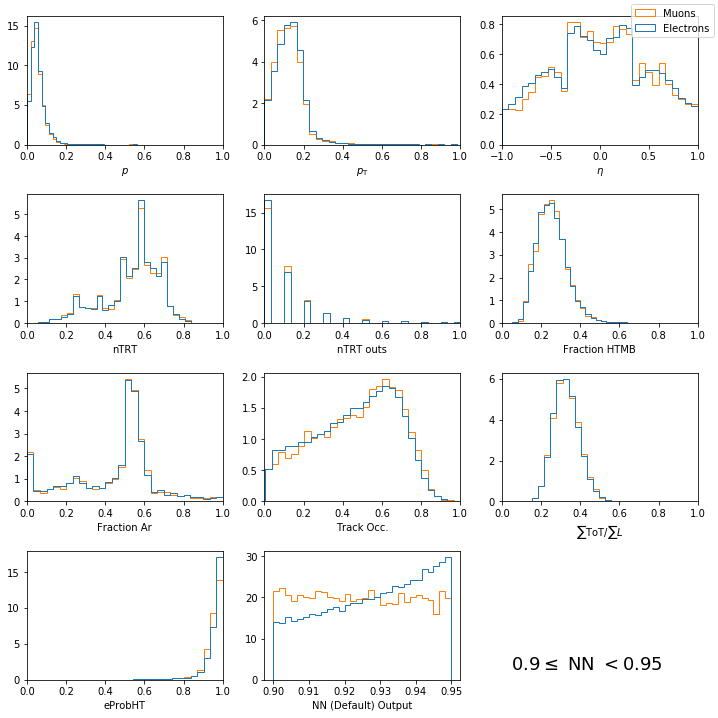

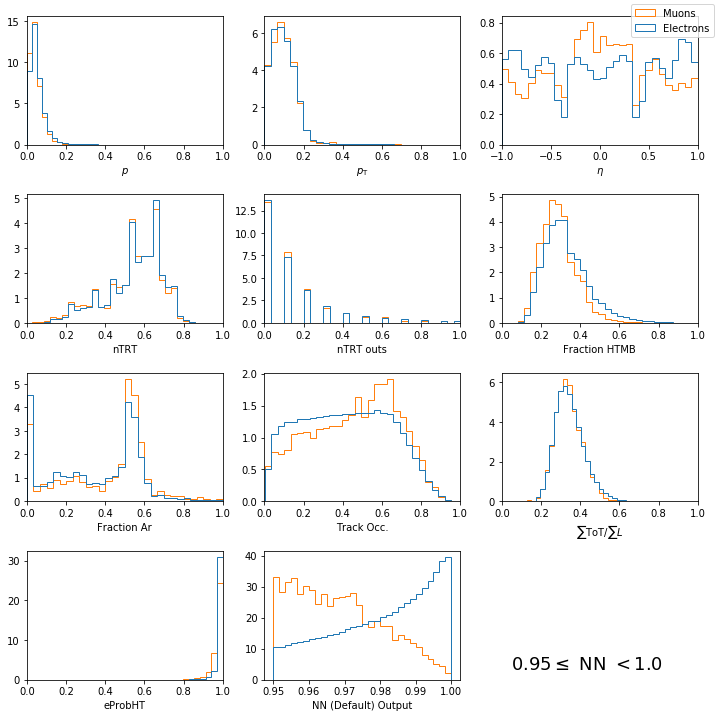

In [26]:
slice_and_plot_all_input_vars('model_default_nn_output', 'NN', model_default_output_bins, 
                              input_variables_with_model_default_output,
                              X_train_with_model_default_output,
                              y_train, plots_path)

## Wide

In [27]:
fname_model_wide = 'model_wide'
train_load_model_wide = train_or_load(models_path+'/'+fname_model_wide+'.h5', default_to_load)

Model NOT found on disk, training


In [28]:
if train_load_model_wide == 'n':
    
    # create
    model_wide = Sequential()
    model_wide.add(Dense(24, input_dim=input_ndimensions, activation='relu'))
    model_wide.add(Dense(16, activation='relu'))
    model_wide.add(Dense(1, activation='sigmoid'))

    model_wide.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_wide = model_wide.fit(X_train, y_train,
                                           epochs=max_epochs, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_wide = hist_model_wide.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_wide.save(models_path+'/'+fname_model_wide+'.h5')
   
    with open(models_path+'/'+fname_model_wide+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_wide, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_wide = load_model(models_path+'/'+fname_model_wide+'.h5')
    
    with open(models_path+'/'+fname_model_wide+'_hist.pickle', 'rb') as handle:
        hist_dict_model_wide = pickle.load(handle)

Train on 1387623 samples, validate on 286530 samples
Epoch 1/20
1387623/1387623 [==============================] - 32s 23us/step - loss: 0.3663 - acc: 0.8380 - val_loss: 0.3735 - val_acc: 0.8314
Epoch 2/20
1387623/1387623 [==============================] - 31s 22us/step - loss: 0.3576 - acc: 0.8412 - val_loss: 0.3695 - val_acc: 0.8333
Epoch 3/20
  95400/1387623 [=>............................] - ETA: 24s - loss: 0.3586 - acc: 0.8418

KeyboardInterrupt: 

In [ ]:
plot_acc_loss_vs_epoch(hist_dict_model_wide, 'NN (wide)', 'nn_wide', plots_path, 'Test', True, False)
plot_acc_loss_vs_epoch(hist_dict_model_wide, 'NN (wide)', 'nn_wide', plots_path, 'Test', False, True)

In [ ]:
print("model_wide %s: %.2f%%" % (model_wide.metrics_names[1], model_wide.evaluate(X_test,y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_wide.predict(X_test[y_test>0.5], verbose=0), # el
                          model_wide.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (wide)', 'nn_wide', plots_path
                         )

fpr_model_wide, tpr_model_wide, thresholds_model_wide = roc_curve(y_test, model_wide.predict(X_test, verbose=0))
roc_model_wide = [tpr_model_wide, fpr_model_wide, 'NN (wide)', 'nn_wide', 'cyan', '-.']

plot_roc([roc_eprob, roc_model_wide], plots_path)

## Deep

In [ ]:
fname_model_deep = 'model_deep'
train_load_model_deep = train_or_load(models_path+'/'+fname_model_deep+'.h5', default_to_load)

In [ ]:
if train_load_model_deep == 'n':
    
    # create
    model_deep = Sequential()
    model_deep.add(Dense(12, input_dim=input_ndimensions, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(1, activation='sigmoid'))

    model_deep.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_deep = model_deep.fit(X_train, y_train,
                                           epochs=max_epochs, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_deep = hist_model_deep.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_deep.save(models_path+'/'+fname_model_deep+'.h5')
   
    with open(models_path+'/'+fname_model_deep+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_deep, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_deep = load_model(models_path+'/'+fname_model_deep+'.h5')
    
    with open(models_path+'/'+fname_model_deep+'_hist.pickle', 'rb') as handle:
        hist_dict_model_deep = pickle.load(handle)

In [ ]:
plot_acc_loss_vs_epoch(hist_dict_model_deep, 'NN (deep)', 'nn_deep', plots_path, 'Test', True, False)
plot_acc_loss_vs_epoch(hist_dict_model_deep, 'NN (deep)', 'nn_deep', plots_path, 'Test', False, True)

In [ ]:
print("model_deep %s: %.2f%%" % (model_deep.metrics_names[1], model_deep.evaluate(X_test,y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_deep.predict(X_test[y_test>0.5], verbose=0), # el
                          model_deep.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (deep)', 'nn_deep', plots_path
                         )

fpr_model_deep, tpr_model_deep, thresholds_model_deep = roc_curve(y_test, model_deep.predict(X_test, verbose=0))
roc_model_deep = [tpr_model_deep, fpr_model_deep, 'NN (deep)', 'nn_deep', 'darkorange', '--']

plot_roc([roc_eprob, roc_model_deep], plots_path)

## k-fold

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold_splits = 10
kfold_max_epochs = 50
kfold_fit_verbose = 0

plots_path_kfold = plots_path+'/kfold'

skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=rnd_seed)

In [ ]:
accs=[]
losses=[]
val_accs=[]
val_losses=[]

for fold_index, (train_indices, val_indices) in enumerate(skf.split(X_train, y_train)):
    print("Training on fold {0:d}/{1:d}".format(fold_index+1, kfold_splits))
    fold_start = datetime.now()
    
    # Generate batches from indices
    this_X_train, this_X_val = X_train[train_indices], X_train[val_indices]
    this_y_train, this_y_val = y_train[train_indices], y_train[val_indices]

    # create
    model_kfold = Sequential()
    model_kfold.add(Dense(12, input_dim=input_ndimensions, activation='relu'))
    model_kfold.add(Dense(8, activation='relu'))
    model_kfold.add(Dense(1, activation='sigmoid'))

    model_kfold.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_kfold = model_kfold.fit(this_X_train, this_y_train,
                                        epochs=kfold_max_epochs, batch_size=50,
                                        verbose=kfold_fit_verbose,
                                        validation_data=(this_X_val, this_y_val));

    
    print(strfdelta(datetime.now()-fold_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # print and save out accs / losses
    hist_dict_model_kfold = hist_model_kfold.history
    
    accs.append(hist_dict_model_kfold['acc'])
    losses.append(hist_dict_model_kfold['loss'])
    val_accs.append(hist_dict_model_kfold['val_acc'])
    val_losses.append(hist_dict_model_kfold['val_loss'])

    kfold_name = 'NN (kfold {:d}/{:d})'.format(fold_index+1, kfold_splits)
    kfold_nname = 'nn_kfold_{:d}'.format(fold_index+1)

    plot_acc_loss_vs_epoch(hist_dict_model_kfold, kfold_name, kfold_nname, plots_path_kfold, 'Validation', True, False)
    plot_acc_loss_vs_epoch(hist_dict_model_kfold, kfold_name, kfold_nname, plots_path_kfold, 'Validation', False, True)
 
    print("On test (not valid) data, this kfold %s: %.2f%%" % (model_kfold.metrics_names[1], model_kfold.evaluate(X_test,y_test,verbose=0)[1]*100))

    plot_classifier_1D_output(model_kfold.predict(X_test[y_test>0.5], verbose=0), # el
                              model_kfold.predict(X_test[y_test<0.5], verbose=0), # mu
                              kfold_name, kfold_nname, plots_path_kfold)

    fpr_model_kfold, tpr_model_kfold, thresholds_model_kfold = roc_curve(y_test, model_kfold.predict(X_test, verbose=0))
    roc_model_kfold = [tpr_model_kfold, fpr_model_kfold, kfold_name, kfold_nname, 'magenta', '--']

    plot_roc([roc_eprob, roc_model_kfold], plots_path_kfold)

    print(strfdelta(datetime.now()-fold_start, "\nTotal fold time: {hours} hours, {minutes} minutes, {seconds} seconds\n"))

In [ ]:
process_kfold_hist_elements(accs, losses, val_accs, val_losses, plots_path, 'NN (kfold)', 'nn_kfold')

## Compare all models

In [ ]:
all_models = []
all_models.append(roc_eprob)
all_models.append(roc_svm1)
all_models.append(roc_model_default)
all_models.append(roc_model_wide)
all_models.append(roc_model_deep)

plot_roc(all_models, plots_path)

roc_model_default_clean = list(roc_model_default)
roc_model_default_clean[2] = 'NN'
roc_model_default_clean[3] += '_clean'
plot_roc([roc_eprob, roc_svm1, roc_model_default_clean], plots_path)

## Mutual Information Plots

### Training Variables

In [ ]:
if plot_mi: mutual_info_plot(var_names_dict, df_sig, 'Training Vars: $e$', 'train_var_el', plots_path)

In [ ]:
if plot_mi: mutual_info_plot(var_names_dict, df_bkg, 'Training Vars: $\mu$', 'train_var_mu', plots_path)

In [ ]:
if plot_mi: mutual_info_plot(var_names_dict,
                             pd.concat([df_sig, df_bkg]),
                             'Training Vars: $e$ & $\mu$', 'train_var_el_mu', plots_path)

### All Variables

In [ ]:
all_vars=[
'p',
'pT',
'eta',
'nTRThitsMan',
'nTRTouts',
'fHTMB',
'fAr',
'trkOcc',
'sumToTsumL',
'lep_pT',
'phi',
'PHF',
'NhitsdEdx',
'sumToT',
'sumL',
'nTRThits',
'nArhits',
'nXehits',
'nHThitsMan',
'nPrechitsMan',
'eProbHT']

if plot_mi:
    df_sig_all_vars = create_df(sig_file_name, sig_tree, all_vars)
    df_bkg_all_vars = create_df(bkg_file_name, bkg_tree, all_vars)

In [ ]:
if plot_mi: mutual_info_plot({var:var for var in all_vars}, df_sig_all_vars, 'All Vars: $e$', 'all_var_el', 'plots')

In [ ]:
if plot_mi: mutual_info_plot({var:var for var in all_vars}, df_bkg_all_vars, 'All Vars: $\mu$', 'all_var_mu', 'plots')

In [ ]:
if plot_mi: mutual_info_plot({var:var for var in all_vars},
                             pd.concat([df_sig_all_vars, df_bkg_all_vars]),
                             'All Vars: $e$ & $\mu$', 'all_var_el_mu', 'plots')

In [ ]:
print("Total elapsed time: %s" % (strfdelta(datetime.now()-time_all_start, "{hours} hours, {minutes} minutes, {seconds} seconds")))

### Make ReLU and Sigmoid diagrams

In [ ]:
x = np.linspace(-10,10,100)

fig, ax = plt.subplots()
y = np.array([max(xi,0) for xi in x])
ax.plot(x, y, lw=2, c='black', ls='-', label='ReLU')
ax.set_xlabel('$x$')
ax.set_xticks([-10,-5,0,5,10])
plt.figtext(0.3, 0.8, '$R(x) = \max(0,x)$', ha='center', va='center', size=16)
plt.title('ReLU');
fig.savefig('plots/relu.pdf')

fig, ax = plt.subplots()
y = np.array([1./(1.+np.exp(-xi)) for xi in x])
ax.plot(x, y, lw=2, c='black', ls='-', label='Sigmoid')
ax.set_xlabel('$x$')
ax.set_xticks([-10,-5,0,5,10])
ax.set_yticks([0,1])
plt.figtext(0.3, 0.8, r'$S(x) = \frac{1}{1+e^{-x}}$', ha='center', va='center', size=16)
plt.title('Sigmoid');
fig.savefig('plots/sigmoid.pdf')

In [98]:
pT_bins_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
eta_bins_list = [-1.0, -0.95, -0.9, -0.85, -0.8, -0.75, -0.7, -0.65, -0.6, -0.55, -0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
pT_bins = np.array(pT_bins_list)
eta_bins = np.array(eta_bins_list)

In [99]:
def weight_pT_eta_uniform(input_variables, X_train, y_train, X_test, y_test):
    var_names = list(input_variables)
    pT_index = var_names.index('pT')
    eta_index = var_names.index('eta')
    
    sig_pT_eta_hist = np.histogram2d( X_train[:,pT_index][y_train>0.5],
                                      X_train[:,eta_index][y_train>0.5],
                                      bins=[pT_bins, eta_bins])[0]
    
    sig_pT_eta_hist[sig_pT_eta_hist <= 0] = 1. # fix div 0 error
    W_sig_pT_eta = np.reciprocal(sig_pT_eta_hist, dtype=float)

    bkg_pT_eta_hist = np.histogram2d( X_train[:,pT_index][y_train<0.5],
                                      X_train[:,eta_index][y_train<0.5],
                                      bins=[pT_bins, eta_bins])[0]
    
    bkg_pT_eta_hist[bkg_pT_eta_hist <= 0] = 1. # fix div 0 error
    W_bkg_pT_eta = np.reciprocal(bkg_pT_eta_hist, dtype=float)

   
    def find_weights(X, y, W_sig_pT_eta, W_bkg_pT_eta):
        w = np.ones(X.shape[0])
        for i,row in enumerate(X):
            W_pT_index = int(np.digitize(row[pT_index], pT_bins))-1
            if row[pT_index] >= pT_bins[-1]: W_pT_index -= 1 # if equal or beyond just use highest bin weight
            
            W_eta_index = int(np.digitize(row[eta_index], eta_bins))-1
            if row[eta_index] >= eta_bins[-1]: W_eta_index -= 1 # if equal or beyond just use highest bin weight

            
            # print("pT %.2f, eta %.2f" %(row[pT_index], row[eta_index]))
            # print("pT index %d, eta index %d" %(W_pT_index, W_eta_index))
            
            if y[i] > 0.5:
                w[i]= W_sig_pT_eta[W_pT_index, W_eta_index]
            else:
                w[i]= W_bkg_pT_eta[W_pT_index, W_eta_index]
                
        return w
    
    w_train = find_weights(X_train, y_train, W_sig_pT_eta, W_bkg_pT_eta)
    w_test = find_weights(X_test, y_test, W_sig_pT_eta, W_bkg_pT_eta)

    return w_train, w_test

In [100]:
w_train, w_test = weight_pT_eta_uniform(input_variables, X_train, y_train, X_test, y_test)

In [130]:
def plot_pT_eta(input_variables, X, y, m_path, name='$p_{\mathrm{T}}$ vs $\eta$}', fname='pT_eta_hist', w = None):
    var_names = list(input_variables)
    pT_index = var_names.index('pT')
    eta_index = var_names.index('eta')
  
    w_sig = None
    w_bkg = None
    if w is not None:
        w_sig = w[y>0.5]
        w_bkg = w[y<0.5]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    vsize = 10 # inches
    aspect_ratio = 2.
    fig.set_size_inches(aspect_ratio*vsize, vsize)
    
    cmap='viridis'
    norm = mpl.colors.Normalize()

    ax1.set_title('Electrons (Sig)')
    ax1.hist2d(X[:,pT_index][y>0.5],
               X[:,eta_index][y>0.5],
               bins=[pT_bins, eta_bins],
               weights=w_sig,
               cmap=cmap, norm=norm)
   
    ax2.set_title('Background')
    img = ax2.hist2d(X[:,pT_index][y<0.5],
               X[:,eta_index][y<0.5],
               bins=[pT_bins, eta_bins],
               weights=w_bkg,
               cmap=cmap, norm=norm)
    
    
    ax1.set_xlabel('$p_{\mathrm{T}}$')
    ax1.set_ylabel('$\eta$')
    ax2.set_xlabel('$p_{\mathrm{T}}$')

    # TODO get working
    # divider = make_axes_locatable(ax2)
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    # cb = plt.colorbar(img, cmap=cmap, norm=norm, cax=cax)
    # plt.colorbar()

    plt.figtext(0.5, 0.95, name, ha='center', va='center', size=16)

    plt.tight_layout()
    make_path(m_path)
    fig.savefig(m_path+'/'+fname+'.pdf')
    plt.show()
    fig.clf()

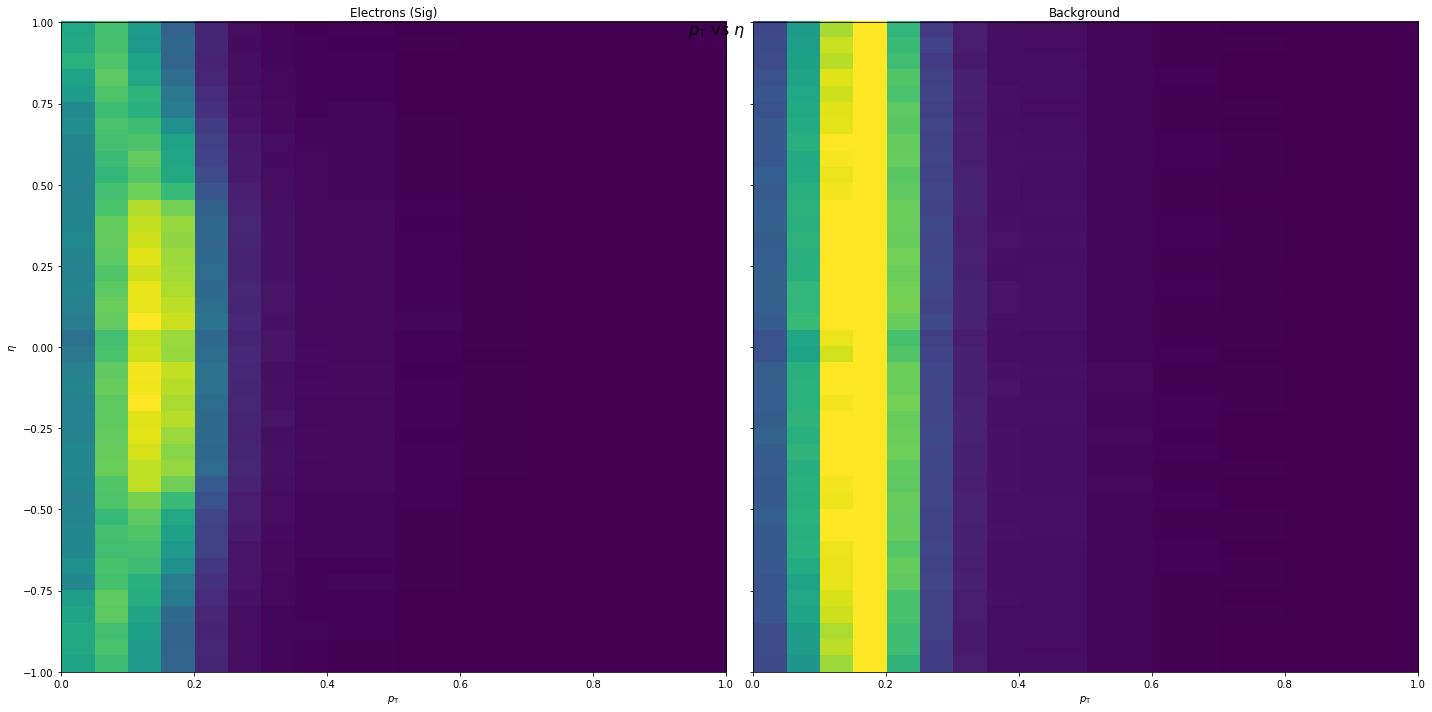

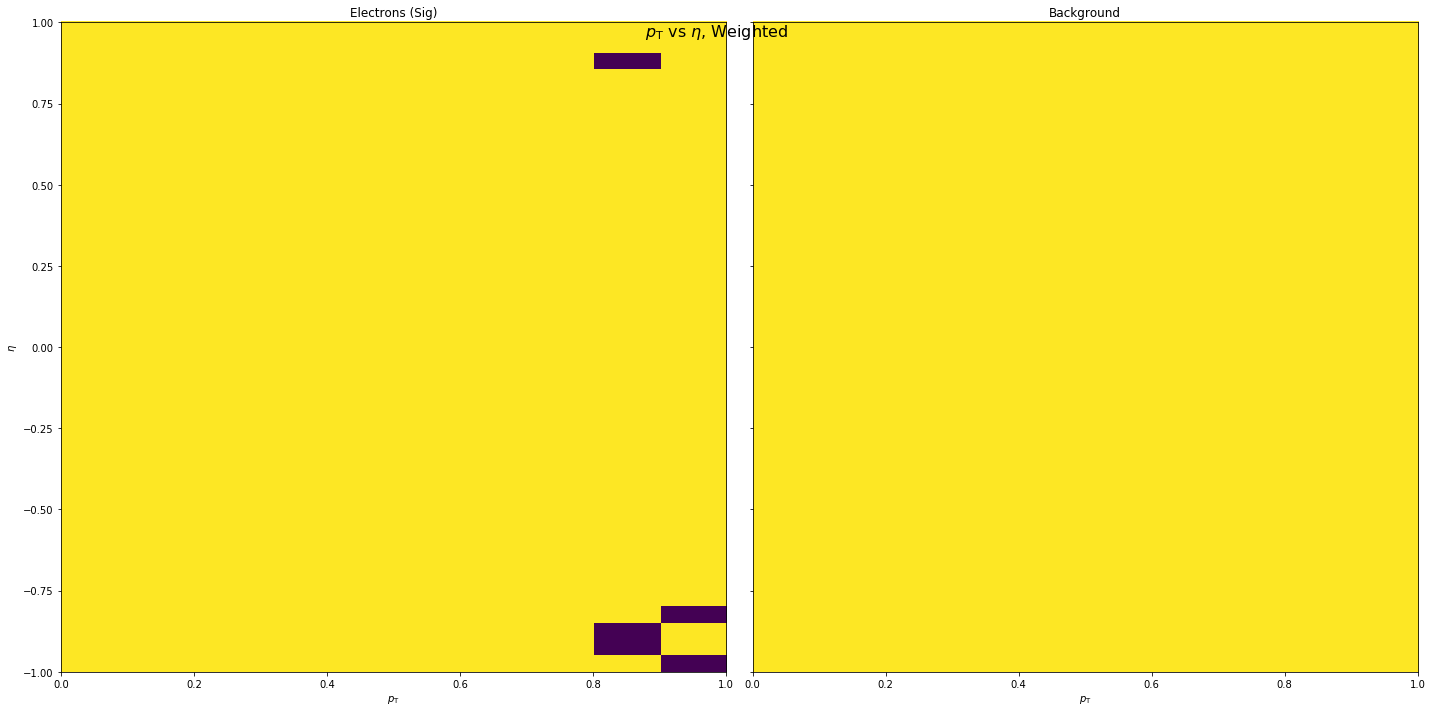

In [131]:
plot_pT_eta(input_variables, X_train, y_train, plots_path, name='$p_{\mathrm{T}}$ vs $\eta$', fname='pT_eta_hist', w = None)
plot_pT_eta(input_variables, X_train, y_train, plots_path, name='$p_{\mathrm{T}}$ vs $\eta$, Weighted', fname='pT_eta_hist_weighted', w = w_train)